In [1]:
import os
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
sns.set(style='darkgrid', context='paper', font_scale=1.2)
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

In [2]:
start_date = pd.Timestamp('2017-01-01')

## Model Training

We simply reuse 10 risk factors provided by BARRA as features to train our model. 

The assumption is that if there are no more information for new risk factors, we will not be able to improve the risk model.

## Main Results

### Factor Performance

1. R^2
2. Global Minimum Variance Portfolio

In [3]:
r2_base = pd.read_pickle(f'data/factor_ret_r2.pkl').loc[start_date:]
r2_stat = pd.read_pickle(f'output_fund/statistical/factor_ret_r2.pkl').loc[start_date:]
r2_deep = pd.read_pickle(f'output_fund/multi-task-lamb0.01-n10/factor_ret_r2.pkl').loc[start_date:]
r2_stat_x2 = pd.read_pickle(f'output_fund/statistical_n20/factor_ret_r2.pkl').loc[start_date:]
r2_deep_x2 = pd.read_pickle(f'output_fund/multi-task-lamb0.01-n20/factor_ret_r2.pkl').loc[start_date:]

FRM         0.297630
SRM         0.301479
DRM         0.303528
SRM (x2)    0.307260
DRM (x2)    0.317041
dtype: float64


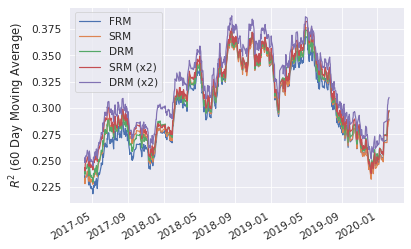

In [4]:
t = pd.DataFrame({
    'FRM': r2_base,
    'SRM': r2_stat,
    'DRM': r2_deep,
    'SRM (x2)': r2_stat_x2,
    'DRM (x2)': r2_deep_x2,
})
print(t.mean())
t.rolling(60).mean().plot(ylabel='$R^2$ (60 Day Moving Average)')
plt.legend(loc='upper left')
plt.savefig('r2.pdf', bbox_inches='tight')

In [5]:
import cvxpy as cp
from tqdm.auto import tqdm

def optimize(path, bench=False, long=False):
    # return data
    W = pd.read_pickle('data/csi300_weight.pkl').loc['2017':]
    R = pd.read_pickle('data/stock_ret.pkl').loc['2017':]
    if bench:
        return (W * R).sum(axis=1), W
    # factor data
    X = pd.read_pickle('data/base.pkl')
    if os.path.exists(path+'/pred.pkl'):
        t = pd.read_pickle(path+'/pred.pkl')
        X = pd.concat([X.loc[t.index[0][0]:].iloc[:, :-10], t], axis=1)
    F = pd.read_pickle(path+'/factor_cov.pkl').loc['2017':]
    U = pd.read_pickle(path+'/resid_vola.pkl').loc['2017':]
    # optimize
    res = dict()
    weights = dict()
    for date in tqdm(F.index.unique(level=0)):
        if date < W.index[0]:
            continue
        w = W.loc[date]
        codes = w[w>0].index.intersection(X.loc[date].index)
        w = w.loc[codes].values
        s = F.loc[date].values
        x = X.loc[date].loc[codes].fillna(0).values
        u = U.loc[date].loc[codes].fillna(0).values
        r = R.loc[date].loc[codes].fillna(0).values
        if long:
            # Long-only
            v = cp.Variable(len(r), nonneg=True)
            vx = v @ x
            obj = cp.Minimize(cp.quad_form(vx, s) + cp.sum(u**2 @ v**2))
            cons = [cp.sum(v) == 1]
            prob = cp.Problem(obj, cons)
            prob.solve(solver=cp.SCS)
            v = np.array(v.value)
        else:
            # Long-short
            S = x @ s @ x.T + np.diag(u**2)
            S_inv = np.linalg.inv(S)
            v = S_inv.sum(axis=1) / S_inv.sum()
        res[date] = v @ r
        weights[date] = pd.Series(v, index=codes)
    return pd.Series(res), pd.DataFrame(weights).T

In [6]:
p_bench, w_bench = optimize('', bench=True)
p_fund, w_fund = optimize('data')
p_stat, w_stat = optimize('output_fund/statistical')
p_stat_x2, w_stat_x2 = optimize('output_fund/statistical_n20')
p_deep, w_deep = optimize('output_fund/multi-task-lamb0.01-n10')
p_deep_x2, w_deep_x2 = optimize('output_fund/multi-task-lamb0.01-n20')

  0%|          | 0/753 [00:00<?, ?it/s]

  0%|          | 0/753 [00:00<?, ?it/s]

  0%|          | 0/753 [00:00<?, ?it/s]

  0%|          | 0/753 [00:00<?, ?it/s]

  0%|          | 0/753 [00:00<?, ?it/s]

<AxesSubplot:>

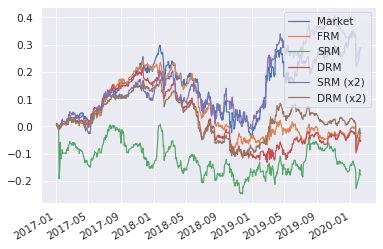

In [7]:
pd.DataFrame({
    'Market': p_bench,
    'FRM': p_fund,
    'SRM': p_stat,
    'DRM': p_deep,
    'SRM (x2)': p_stat_x2,
    'DRM (x2)': p_deep_x2,
}).cumsum().plot()

In [8]:
p_fund_long, w_fund_long = optimize('data', long=True)
p_stat_long, w_stat_long = optimize('output_fund/statistical', long=True)
p_stat_x2_long, w_stat_x2_long = optimize('output_fund/statistical_n20', long=True)
p_deep_long, w_deep_long = optimize('output_fund/multi-task-lamb0.01-n10', long=True)
p_deep_x2_long, w_deep_x2_long = optimize('output_fund/multi-task-lamb0.01-n20', long=True)

  0%|          | 0/753 [00:00<?, ?it/s]

  0%|          | 0/753 [00:00<?, ?it/s]

  0%|          | 0/753 [00:00<?, ?it/s]

  0%|          | 0/753 [00:00<?, ?it/s]

  0%|          | 0/753 [00:00<?, ?it/s]

<AxesSubplot:>

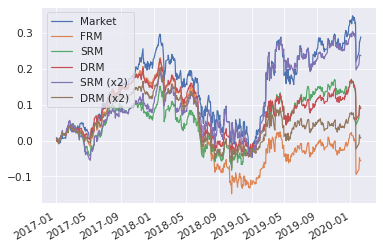

In [9]:
pd.DataFrame({
    'Market': p_bench,
    'FRM': p_fund_long,
    'SRM': p_stat_long,
    'DRM': p_deep_long,
    'SRM (x2)': p_stat_x2_long,
    'DRM (x2)': p_deep_x2_long,
}).cumsum().plot()

In [10]:
t = pd.DataFrame({
    'R2': pd.DataFrame({
        'FRM': r2_base,
        'SRM': r2_stat,
        'DRM': r2_deep,
        'SRM (x2)': r2_stat_x2,
        'DRM (x2)': r2_deep_x2,
    }).mean().mul(100).round(1).astype(str) + '%',
    'GMV': pd.DataFrame({
        'Market': p_bench,
        'FRM': p_fund,
        'SRM': p_stat,
        'DRM': p_deep,
        'SRM (x2)': p_stat_x2,
        'DRM (x2)': p_deep_x2,
    }).std().mul(252**0.5).mul(100).round(1).astype(str) + '%',
    'GMV+': pd.DataFrame({
        'Market': p_bench,
        'FRM': p_fund_long,
        'SRM': p_stat_long,
        'DRM': p_deep_long,
        'SRM (x2)': p_stat_x2_long,
        'DRM (x2)': p_deep_x2_long,
    }).std().mul(252**0.5).mul(100).round(1).astype(str) + '%',
}).loc[['Market', 'FRM', 'SRM', 'SRM (x2)', 'DRM', 'DRM (x2)']].fillna('-')
t.columns.name = 'Risk Model'
print(t.to_latex())
t

\begin{tabular}{llll}
\toprule
Risk Model &     R2 &    GMV &   GMV+ \\
\midrule
Market   &      - &  18.4\% &  18.4\% \\
FRM      &  29.8\% &  12.6\% &  12.9\% \\
SRM      &  30.1\% &  18.6\% &  13.5\% \\
SRM (x2) &  30.7\% &  16.5\% &  16.2\% \\
DRM      &  30.4\% &  12.3\% &  12.9\% \\
DRM (x2) &  31.7\% &  11.6\% &  12.3\% \\
\bottomrule
\end{tabular}



Risk Model,R2,GMV,GMV+
Market,-,18.4%,18.4%
FRM,29.8%,12.6%,12.9%
SRM,30.1%,18.6%,13.5%
SRM (x2),30.7%,16.5%,16.2%
DRM,30.4%,12.3%,12.9%
DRM (x2),31.7%,11.6%,12.3%


### Factor Characteristics

1. Significance: T-value
2. Multicollinearity: VIF
3. Stability: Auto Correlation

In [11]:
df = pd.read_pickle('output_fund/multi-task-lamb0.01-n10/pred.pkl').loc[pd.Timestamp(start_date):]
df.columns = ['RISK%d'%d for d in range(df.shape[1])]

In [12]:
vif = df.groupby(level=0).apply(lambda x: pd.Series(np.diag(np.linalg.inv(x.T@x/len(x))), index=x.columns))

In [13]:
autocorr = lambda x: x.corrwith(x.shift(1), axis=1, method='spearman')
corr = pd.DataFrame({col: autocorr(df[col].unstack()) for col in df.columns})

In [14]:
tval = pd.read_pickle(f'output_fund/multi-task-lamb0.01-n10/factor_ret_tval.pkl').loc[start_date:]
t = pd.DataFrame({
    'Mean |t|': tval.abs().mean(),
    'Pct |t|>2': tval.abs().gt(2).mean(),
    'VIF': vif.mean(),
    'Auto Corr.': corr.mean(),
}).reindex(vif.columns).round(3)
t['Pct |t|>2'] = t['Pct |t|>2'].mul(100).round(1).astype(str)+'%'
t.index = range(len(t))
t.columns.name = 'Factor ID'
print(t.to_latex())
t

\begin{tabular}{lrlrr}
\toprule
Factor ID &  Mean |t| & Pct |t|>2 &    VIF &  Auto Corr. \\
\midrule
0 &     4.878 &     72.9\% &  0.984 &       0.995 \\
1 &     3.559 &     65.9\% &  1.301 &       0.995 \\
2 &     2.748 &     55.0\% &  1.180 &       0.997 \\
3 &     2.173 &     45.9\% &  1.277 &       0.998 \\
4 &     3.244 &     59.0\% &  1.309 &       0.997 \\
5 &     2.831 &     56.0\% &  1.163 &       0.966 \\
6 &     3.461 &     64.7\% &  1.007 &       0.994 \\
7 &     2.697 &     56.8\% &  1.211 &       0.966 \\
8 &     3.247 &     60.3\% &  1.293 &       0.990 \\
9 &     2.699 &     55.6\% &  1.104 &       0.985 \\
\bottomrule
\end{tabular}



Factor ID,Mean |t|,Pct |t|>2,VIF,Auto Corr.
0,4.878,72.9%,0.984,0.995
1,3.559,65.9%,1.301,0.995
2,2.748,55.0%,1.180,0.997
3,2.173,45.9%,1.277,0.998
4,3.244,59.0%,1.309,0.997
5,2.831,56.0%,1.163,0.966
6,3.461,64.7%,1.007,0.994
7,2.697,56.8%,1.211,0.966
8,3.247,60.3%,1.293,0.990
9,2.699,55.6%,1.104,0.985


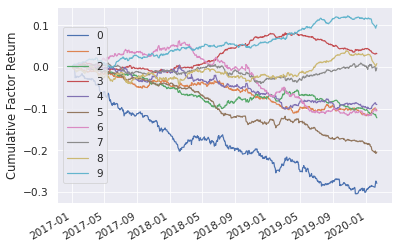

In [15]:
factor_ret = pd.read_pickle('output_fund/multi-task-lamb0.01-n10/factor_ret.pkl').loc[pd.Timestamp(start_date):]
t = factor_ret.iloc[:, 30:].cumsum()
t.columns = range(t.shape[1])
t.columns.name = 'Factor ID'
t.plot(ylabel='Cumulative Factor Return').legend(loc='center left')
plt.savefig('factor_ret.pdf', bbox_inches='tight')

## Incremental Analysis

### GAT

In [16]:
res = dict()
for n in [10, 12, 14, 16, 18, 20]:
    res[n] = pd.Series({
        'w/ GAT': pd.read_pickle(f'output_fund/multi-task-lamb0.01-n{n}/factor_ret_r2.pkl').loc[start_date:].mean(),
        'w/o GAT': pd.read_pickle(f'output_fund/multi-task-lamb0.01-n{n}-nogat/factor_ret_r2.pkl').loc[start_date:].mean()
    })
t = pd.DataFrame(res).mul(100).round(1).astype(str).add('%')
print(t.to_latex())
t

\begin{tabular}{lllllll}
\toprule
{} &     10 &     12 &     14 &     16 &     18 &     20 \\
\midrule
w/ GAT  &  30.4\% &  30.6\% &  30.8\% &  31.1\% &  31.4\% &  31.7\% \\
w/o GAT &  30.3\% &  30.5\% &  30.9\% &  31.1\% &  31.3\% &  31.5\% \\
\bottomrule
\end{tabular}



,10,12,14,16,18,20
w/ GAT,30.4%,30.6%,30.8%,31.1%,31.4%,31.7%
w/o GAT,30.3%,30.5%,30.9%,31.1%,31.3%,31.5%


### Multicollinearity Regularization

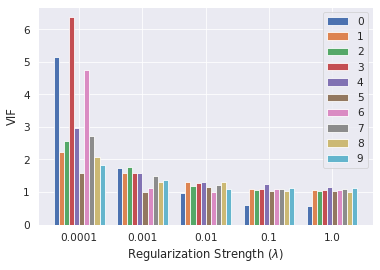

In [17]:
res = dict()
for lamb in [0.0001, 0.001, 0.01, 0.1, 1.0]:
    try:
        df = pd.read_pickle(f'output_fund/multi-task-lamb{lamb}-n10/pred.pkl').loc[start_date:]
        vif = df.groupby(level=0).apply(lambda x: pd.Series(np.diag(np.linalg.inv(x.T@x/len(x))), index=x.columns))
        res[lamb] = vif.mean()
    except:
        continue
vif = pd.DataFrame(res).T
vif.plot.bar(ylabel='VIF', xlabel='Regularization Strength ($\lambda$)', rot=0, width=0.8)
plt.savefig('vif.pdf', bbox_inches='tight')

### Multi-Task vs Single-Task

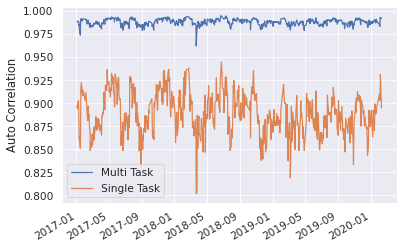

In [18]:
df0 = pd.read_pickle('output_fund/multi-task-lamb0.01-n10/pred.pkl').loc[start_date:]
df1 = pd.read_pickle('output_fund/single-task-lamb0.01-n10/pred.pkl').loc[start_date:]

autocorr = lambda x: x.corrwith(x.shift(1), axis=1, method='spearman')
t = pd.DataFrame({
    'Multi Task': pd.concat([autocorr(df0.iloc[:, i].unstack()) for i in range(10)], axis=1).mean(axis=1),
    'Single Task': pd.concat([autocorr(df1.iloc[:, i].unstack()) for i in range(10)], axis=1).mean(axis=1),
})
t.plot(ylabel='Auto Correlation')
plt.savefig('auto_corr.pdf', bbox_inches='tight')